# Продвинутое машинное обучение: ДЗ №1

**Булаев Владимир, группа DS-22, 18-27.02.2021**

Примечание:
- В первой части работы все графики интерактивные: можно их увеличивать/уменьшать и крутить
- По непонятным причинам графики plotly не отображаются ни на github, ни в Colab 
- Для решения всех проблем с отображением выложил файл по этому адресу: https://nbviewer.jupyter.org/github/bulaevvi/Advanced-ML/blob/main/AdvancedML_HW1.ipynb
- Ссылка на оригинальный файл в репозитории: https://github.com/bulaevvi/Advanced-ML/blob/main/AdvancedML_HW1.ipynb  
- Если планируете запускать ноутбук локально, для корректного отображения графиков plotly в оффлайн-режиме необходимо сделать jupyter-notebook Trusted (нажатькнопку "Trusted" в правом верхнем углу).

In [3]:
# Используемые бибилиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime

import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

import plotly.graph_objects as go
# Для возможности отображения графиков plotly в оффлайн-режиме
import plotly.io as pio
pio.renderers.default = 'notebook'

# Чтобы не загромождать вывод предупреждениями
import warnings
warnings.filterwarnings("ignore")

## Содержание: <a class="anchor" id="zero-bullet"></a>
* [Часть I](#I-part)
* [I.1. Довод прокурора](#I.1)
* [I.2. Довод адвоката](#I.2)
* [I.3. Задача про страшную болезнь](#I.3)
    * [Анализ апостериорной вероятности болезни после положительного теста](#I.3a)
    * [Анализ апостериорной вероятности болезни после отрицательного теста](#I.3b)
    * [Совместный анализ апостериорных вероятностей](#I.3c)
* [Часть II](#II-part)
* [II.1. Загрузка данных](#II.1)
* [II.2. Использование экспоненциальной модели](#II.2)
    * [II.2.a. Линейная модель для экспоненциальной зависимости](#II.2.a)
    * [II.2.b. Апостериорное распределение параметров](#II.2.b)
    * [II.2.c. Сэмплирование экспонент](#II.2.c)
* [II.3. Использование сигмоидной модели](#II.3)
    * [II.3.a. Линейная модель для сигмоиды](#II.3.a)
    * [II.3.b. Апостериорное распределение параметров](#II.3.b)
    * [II.3.c. Сэмплирование сигмоид](#II.3.c)
* [II.4. Анализ по другим странам](#II.4)
    * [II.4.1. Экспоненциальная модель](#II.4.1)
    * [II.4.2. Сигмоидальная модель](#II.4.2)
* [Сравнение результатов по странам](#II.5)

## Часть I. О теореме Байеса <a class="anchor" id="I-part"></a>

Условие задачи: *Произошло убийство. На месте убийства найдена кровь, которая явно (будем считать, что с вероятностью 1) принадлежит настоящему убийце. Кровь принадлежит редкой группе, которая присутствует всего лишь у 1% населения. И так получилось, что у подсудимого как раз эта редкая группа крови!*

### I.1. Довод прокурора <a class="anchor" id="I.1"></a>
*“Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен - всего 1%; значит, с вероятностью 99% он виновен, предлагаю осудить”. В чём не прав прокурор? Укажите, какие вероятности он оценил, а какие должен был оценить.*

**Ответ:** на суде прокурор оценил вероятность того, что у подсудимого будет редкая группа крови при условии, что он убийца. На самом деле он должен был оценить вероятность того, что подозреваемый является убийцей при условии, что у него редкая группа крови.

[К содержанию](#zero-bullet) 

### I.2. Довод адвоката <a class="anchor" id="I.2"></a>  
*“В городе живёт миллион человек. Это значит, что примерно у 10000 из них такая группа крови. Значит, всё, что говорит нам эта кровь - это то, что подсудимый совершил убийство с вероятностью 0.01%. Получается, что это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен, так что предлагаю исключить его из материалов дела”. В чём не прав адвокат? Какие вероятности он оценил, а какие должен был оценить?*

**Ответ:** на суде адвокат оценил вероятность того, что случайно выбранный житель города может быть убийцей при условии, что у него редкая группа крови. На самом деле он должен был оценить вероятность того, что подозреваемый может быть убийцей при условии, что у него редкая группа крови.

[К содержанию](#zero-bullet) 

### I.3. Задача про страшную болезнь <a class="anchor" id="I.3"></a>
Условие задачи: *Вернёмся к тесту на страшную болезнь из первой лекции. Напомню, что по предположениям задачи болеет 1% населения, а тест имеет вероятность ошибки 5% в обе стороны. Мы видели, что в результате человек с положительным тестом имеет апостериорную вероятность оказаться больным всего лишь около 16%. Врачи решили, что терпеть это никак нельзя; они готовы провести срочное исследование и улучшить качество теста. Но сил и денег хватит только для того, чтобы сократить один тип ошибок, т.е. уменьшить или только число false positives (когда тест выдаёт положительный результат у здорового человека), или только число false negatives (когда тест выдаёт отрицательный результат у больного). Помогите медикам: постройте зависимости апостериорной вероятности болезни после положительного и отрицательного теста от обоих видов ошибок (например, в виде графиков), сделайте выводы и дайте рекомендации врачам - на чём лучше сосредоточиться?*

**Решение**  

Распишем вероятности, которые фигурируют в задаче:  
**P(sick)** - вероятность иметь страшную болезнь. По условию P(sick) = 0.01  
**P(good)** - вероятность не иметь страшную болезнь. P(good) = 1 - P(sick) = 0.99  
**P("+")** - вероятность того, что тест на страшную болезнь будет положительным  
**P("-")** - вероятность того, что тест на страшную болезнь будет отрицательным. P("-") = 1 - P("+")  
**P("-" | sick) = P(false negatives) = FN** - вероятность отрицательного теста при условии, что человек болен. P("-" | sick) + P("+" | sick) = 1. По условию задачи, вероятности ошибки тестов в обе стороны (т.е. false negatives и false positives) изначально одинаковы и равны 0.05  
**P("+" | sick)** - вероятность положительного теста при условии, что человек болен. P("+" | sick) = 1 - P("-" | sick) = 0.95   
**P("+" | good) = P(false positives) = FP** - вероятность положительного теста при условии, что человек не болен. Изначально P("+" | good) = 0.05.  P("+" | good) + P("-" | good) = 1    
**P("-" | good)** - вероятность отрицательного теста при условии, что человек не болен. P("-" | good) = 1 - P("+" | good) = 0.95     

Необходимо найти:  
**P(sick | "+")** - апостериорная вероятность болезни после положительного теста  
**P(sick | "-")** - апостериорная вероятность болезни после отрицательного теста  
Для этого воспользуемся формулой Байеса:

$$P(sick | "+") = \frac{P("+" | sick) \cdot P(sick)}{P("+")}$$

Распишем P("+"), используя формулу полной вероятности, и получим апостериорную вероятность болезни после положительного теста:

$$P(sick | "+") = \frac{P("+" | sick) \cdot P(sick)}{P("+" | sick) \cdot P(sick) + P("+" | good) \cdot P(good)}$$

Используя аналогичные рассуждения, получим формулу для оценки апостериорной вероятности болезни после отрицательного теста:  

$$P(sick | "-") = \frac{P("-" | sick) \cdot P(sick)}{P("-" | sick) \cdot P(sick) + P("-" | good) \cdot P(good)}$$

[К содержанию](#zero-bullet) 

#### Анализ апостериорной вероятности болезни после положительного теста <a class="anchor" id="I.3a"></a>

Распишем формулу для вычисления апостериорной вероятности болезни после положительного теста. Учитывая, что  
P("+" | good) = FP  
P("+" | sick) = 1 - P("-" | sick) = 1 - FN  
подставив численные значения, получим окончательную формулу:

$$P(sick | "+")=\frac{(1-FN)\cdot P(sick)}{(1-FN)\cdot P(sick) + FP\cdot P(good)}=\frac{0.01-0.01FN}{0.01-0.01FN + 0.99FP}$$

Для анализа поведения функции P(sick | "+") в зависимости от значений FN и FP построим ее график

In [4]:
# Функция для расчета апостериорной вероятности болезни после положительного теста
def p_sick_pos(fn, fp):
    return (0.01 - 0.01 * fn) / (0.01 - 0.01 * fn + 0.99 * fp)

In [5]:
step = 0.01  # Шаг по осям
# Рассмотрим весь возможный диапазон изменений FN и FP: [0, 1]
fn = np.arange(0, 1 + step, step)  
fp = np.arange(0, 1 + step, step)
# Создаем сетку, в которой будем вычислять значения функции
xx, yy = np.meshgrid(fn, fp)  
# Расчитаем значения целевой функции
z = p_sick_pos(xx, yy)

In [6]:
# Функция для отрисовки графиков
def plot(fn, fp, z, step, title, zaxis_title):
    fig = go.Figure(go.Surface(
                            contours = {"x": {"show": True, "start": fn[0], "end": fn[-1], "size": step, "color":"white"},
                                        "y": {"show": True, "start": fp[0], "end": fp[-1], "size": step, "color":"magenta"}},
                            x = fn, y = fp, z = z))
    fig.update_layout(
            title = title,
            scene = {"xaxis": {"nticks": 10},
                     "yaxis": {"nticks": 10},
                     "zaxis": {"nticks": 4},
                    'camera_eye': {"x": -0.8, "y": 0.4, "z": 0.3},
                    "aspectratio": {"x": 0.5, "y": 0.5, "z": 0.3},
                    "xaxis_title": "FN",
                    "yaxis_title": "FP",
                    "zaxis_title": zaxis_title,}
            )
    fig.show()

title = 'График зависимости P(sick | "+") от FN и FP в диапазоне входных значений [0, 1]'
plot(fn, fp, z, step * 5, title, 'P(sick|"+")')

*Общий характер зависимости такой: чем меньше значение FN и FP, тем выше апостериорная вероятность болезни при условии положительного теста.*   

Для принятия решения о том, на улучшении какого из показателей лучше сконцентрировать исилия, на графике приведены поперечные сечения вдоль осей FN и FP. Белыми линиями показано сечение целевой функции вертикальными плоскостями, параллельными оси FP (т.е. зависимость величины целевой функции P(sick|"+") от изменения значение FP при фиксированном FN).  
Малиновыми линиями показано сечение целевой функции вертикальными плоскостями, параллельными оси FN (т.е. зависимость величины целевой функции P(sick|"+") от изменения значение FN при фиксированном FP).  



Поскольку по условиям задачи изначально FN и FP были равны 0.05, рассмотрим более детально диапазон изменений FN и FP: [0, 0.1]

In [7]:
step_crop = 0.001  # Шаг по осям
# Рассмотрим весь возможный диапазон изменений FN и FP: [0, 0.1]
fn_crop = np.arange(0, 0.1 + step_crop, step_crop)  
fp_crop = np.arange(0, 0.1 + step_crop, step_crop)
# Создаем сетку, в которой будем вычислять значения функции
xx_crop, yy_crop = np.meshgrid(fn_crop, fp_crop)  
# Расчитаем значения целевой функции
z_crop = p_sick_pos(xx_crop, yy_crop)

title = 'График зависимости P(sick | "+") от FN и FP в диапазоне входных значений [0, 0.1]'
plot(fn_crop, fp_crop, z_crop, step_crop * 5, title, 'P(sick|"+")')

Важно, чтобы апостериорная вероятность болезни после положительного теста возрастала. Для этого необходимо уменьшать значения FP и FN. Но на графике видно, что уменьшение FN при фиксированном FP ведет к незначительному росту целевой функции (малиновые линии носят характер парабол, причем в интервале [0, 0.1] они находятся в зоне насыщения).  

В то же время влияние изменения FP при фиксированном FN на целевую функцию носит гиперболический характер - небольшое уменьшение FP сильнее увеличивает целевую функцию, чем аналогичное изменение FN.

*Вывод: для увеличения апостериорной вероятности болезни при условии положительного теста лучше сконцентрировать усилия по уменьшению вероятности false positive.*

[К содержанию](#zero-bullet) 

#### Анализ апостериорной вероятности болезни после отрицательного теста <a class="anchor" id="I.3b"></a>

Распишем формулу для вычисления апостериорной вероятности болезни после положительного теста. Учитывая, что  
P("-" | sick) = FN  
P("-" | good) = 1 - P("+" | good) = 1 - FP  
подставив численные значения, получим окончательную формулу:

$$P(sick | "-")=\frac{FN\cdot P(sick)}{FN\cdot P(sick) + (1-FP)\cdot P(good)}=\frac{0.01FN}{0.99+0.01FN-0.99FP}$$

Для анализа поведения функции P(sick | "-") в зависимости от значений FN и FP построим ее график

In [8]:
# Функция для расчета апостериорной вероятности болезни после отрицательного теста
def p_sick_neg(fn, fp):
    return 0.01 * fn / (0.99 + 0.01 * fn - 0.99 * fp)
step = 0.01  # Шаг по осям
# Рассмотрим весь возможный диапазон изменений FN и FP: [0, 1]
fn = np.arange(0, 1 + step, step)  
fp = np.arange(0, 1 + step, step)
# Создаем сетку, в которой будем вычислять значения функции
xx, yy = np.meshgrid(fn, fp)  
# Расчитаем значения целевой функции
z = p_sick_neg(xx, yy)

title = 'График зависимости P(sick | "-") от FN и FP в диапазоне входных значений [0, 1]'
plot(fn, fp, z, step * 5, title, 'P(sick|"-")')

*Общий характер зависимости такой: чем меньше значение FN и FP, тем ниже апостериорная вероятность болезни при условии отрицательного теста.*

По аналогии, здесь белыми линиями показано сечение целевой функции вертикальными плоскостями, параллельными оси FP (т.е. зависимость величины целевой функции P(sick|"-") от изменения значение FP при фиксированном FN).
Малиновыми линиями показано сечение целевой функции вертикальными плоскостями, параллельными оси FN (т.е. зависимость величины целевой функции P(sick|"-") от изменения значение FN при фиксированном FP).

Поскольку по условиям задачи изначально FN и FP были равны 0.05, рассмотрим более детально диапазон изменений FN и FP: [0, 0.1]

In [9]:
step_crop = 0.001  # Шаг по осям
# Рассмотрим весь возможный диапазон изменений FN и FP: [0, 0.1]
fn_crop = np.arange(0, 0.1 + step_crop, step_crop)  
fp_crop = np.arange(0, 0.1 + step_crop, step_crop)
# Создаем сетку, в которой будем вычислять значения функции
xx_crop, yy_crop = np.meshgrid(fn_crop, fp_crop)  
# Расчитаем значения целевой функции
z_crop = p_sick_neg(xx_crop, yy_crop)

title = 'График зависимости P(sick | "-") от FN и FP в диапазоне входных значений [0, 0.1]'
plot(fn_crop, fp_crop, z_crop, step_crop * 5, title, 'P(sick|"-")')

Важно, чтобы апостериорная вероятность болезни после отрицательного теста снижалась. Для этого необходимо уменьшать значения FP и FN. На графике видно, что уменьшение FN при фиксированном FP ведет к более существенному снижению целевой функции (малиновые линии имеют более сильнй наклон, чем белые).  

В то же время влияние изменения FP при фиксированном FN на целевую функцию носит слабый характер.

*Вывод: для снижения апостериорной вероятности болезни при условии отрицательного теста лучше сконцентрировать усилия по уменьшению вероятности false negative.*

[К содержанию](#zero-bullet) 

#### Совместный анализ апостериорных вероятностей <a class="anchor" id="I.3c"></a>

Возникает дилемма:  
- для увеличения апостериорной вероятности болезни после положительного теста лучше снижать вероятность false positive
- для снижения апостериорной вероятности болезни после отрицательного теста лучше снижать вероятность false negative

Чтобы принять окончательное решение, что же лучше всего делать врачам в данной ситуации, составим целевую функцию target, равную разности апостериорных вероятностей болезней после получения положительного и отрицательного теста:  

$$Target=P(sick|"+")-P(sick|"-")$$

Разность была использована потому, что:  
- Обе функции имеют один и тот же диапазон значений и физический смысл
- Вариант с делением одной функции на другую, т.е. P(sick|"+")/P(sick|"-"), может привести к некорректным результатам, т.к. в области оптимизируемых значений аргумента (т.е. возле нуля) значение P(sick|"-") стремится к нулю   

Максимизация выбранной целевой функции будет увеличивать апостериорную вероятность болезни после положительного теста и снижать апостериорную вероятность болезни после отрицательного теста.  

Рассмотрим поведение графика этой функции в диапазоне изменений FN и FP: [0, 0.1]

In [10]:
step_crop = 0.001  # Шаг по осям
# Рассмотрим весь возможный диапазон изменений FN и FP: [0, 0.1]
fn_crop = np.arange(0, 0.1 + step_crop, step_crop)  
fp_crop = np.arange(0, 0.1 + step_crop, step_crop)
# Создаем сетку, в которой будем вычислять значения функции
xx_crop, yy_crop = np.meshgrid(fn_crop, fp_crop)  
# Расчитаем значения целевой функции
target = p_sick_pos(xx_crop, yy_crop) - p_sick_neg(xx_crop, yy_crop)

title = 'График зависимости P(sick|"+") - P(sick|"-") от FN и FP в диапазоне входных значений [0, 0.1]'
plot(fn_crop, fp_crop, target, step_crop * 5, title, 'Target')

Важно, чтобы целевая функция возрастала. Для этого необходимо уменьшать значения FP и FN. Но на графике видно, что уменьшение FN при фиксированном FP ведет к незначительному росту целевой функции (малиновые линии носят пологий характер).  

В то же время влияние изменения FP при фиксированном FN на целевую функцию носит гиперболический характер - небольшое уменьшение FP сильнее увеличивает целевую функцию, чем аналогичное изменение FN.

Несмотря на тот факт, что уменьшение FP не так выигрышно для снижения апостериорной вероятности болезни после отрицательного теста, это с большим запасом компенсируется выигрышем от возрастания апостериорной вероятности болезни после положительного теста.

**Ответ: в целом врачам лучше сконцентрировать усилия по уменьшению вероятности false positive.**

[К содержанию](#zero-bullet) 

## Часть II. О линейной регрессии <a class="anchor" id="II-part"></a>  
Эта часть первого домашнего задания связана с анализом конкретного датасета. Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей ссылке:
https://ourworldindata.org/coronavirus-source-data

### II.1. Загрузка данных <a class="anchor" id="II.1"></a>   
*Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания). Иначе говоря, мы будем “играть” за российские власти, которые пытаются понять, что делать, глядя на данные об эпидемии в мае 2020 года.*  

In [11]:
# Скачаем данные
# !wget https://covid.ourworldindata.org/data/owid-covid-data.csv

Сделаем предобработку данных:  
- уберем лишние столбцы из датафрейма
- выберем данные по нужной стране, начиная с некоторой даты (для задачи II.1 это Россия, начиная с 3 марта 2020 г.)
- нулевые данные заменим единицами

In [12]:
# Страна и дата, начиная с которой будем рассматривать данные
COUNTRY = 'Russia'
START_DATE = datetime.datetime(2020, 3, 3)

# Считываем данные
df = pd.read_csv('owid-covid-data.csv', parse_dates= ['date'])
# Оставляем только нужные столбцы
df = df[['location', 'date', 'total_cases', 'new_cases']]
# Выбираем страну и дату, с которой начнем обработку
df = df[(df['location'] == COUNTRY) & (df['date'] >= START_DATE)]
# Исправляем нулевые значения на единичные
zero_elements = df[df['new_cases'] <= 0].index
df.loc[df.index.isin(zero_elements), 'new_cases'] = 1
df = df.reset_index(drop = True)

*Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.*

array([[<AxesSubplot:xlabel='Дни, начиная с 2020-03-03', ylabel='Количество'>,
        <AxesSubplot:xlabel='Дни, начиная с 2020-03-03', ylabel='Количество'>]],
      dtype=object)

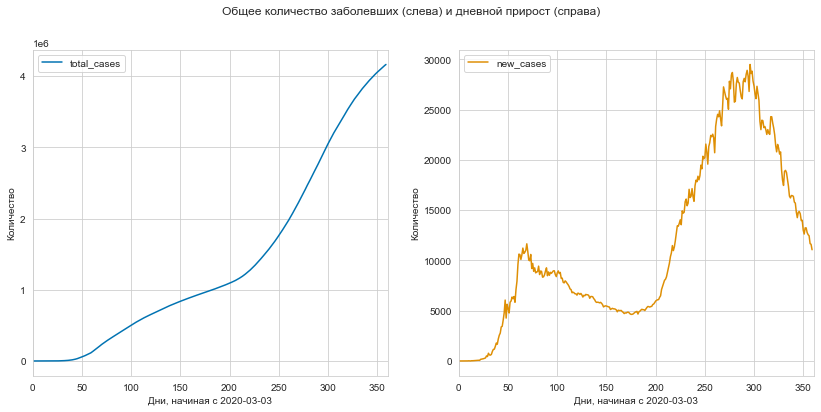

In [13]:
df[['total_cases', 'new_cases']].plot(kind='line', subplots=True, grid=True, 
                                      title= 'Общее количество заболевших (слева) и дневной прирост (справа)',
                                      layout=(1, 2), sharex=True, sharey=False, legend=True,
                                      figsize = (14, 6), xlim = (0, len(df) + 1), 
                                      xlabel = 'Дни, начиная с ' + str(START_DATE.date()),
                                      ylabel = 'Количество')

Экспоненциальный рост количества вновь заболевших наблюдается только примерно в первые 60-65 дней, а также в период со 170 по 230 день.  

По исходным данным видно, что:  
- Характер изменения количества вновь заболевших очень сильно меняется со временем, как по характеру изменения (возрастание/убывание), так и по динамике роста/спада. Если пытаться описать всю наблюдаемую кривую одной линейно-экспоненциальной моделью, то получится очень плохой результат. Но на начальном этапе пандемии можно увидеть, что рост действительно был похож на экспоненциальный.   
- Общее количество заболевших в целом носит более сглаженный характер. В целом можно заметить, что на начальном этапе функция возрастает очень медленно, потом темп роста увеличивается, и затем кривая начинает входить в зону насыщения. Для моделирования кривых такого характера лучше подходит сигмоидальная модель.

[К содержанию](#zero-bullet) 

### II.2. Использование экспоненциальной модели <a class="anchor" id="II.2"></a>  


Экспоненциальная зависимость будет использована для моделирования количества вновь заболевших людей (new_cases).

#### II.2.a. Линейная модель для экспоненциальной зависимости <a class="anchor" id="II.2.a"></a>  
*Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x) , где x — номер текущего дня.*  

Распишем подробнее входные и выходные данные. В задаче требуется построить модель для предсказания количества заболевших людей в определенный момент времени, начиная с некоторой начальной даты (для России - с 3 марта 2020 г.). Таким образом, входы для модели - это номера дней от даты старта, т.е. x - это целое число. Целевая переменная y - количество заболевших людей (целое неотрицательное число), значит мы решаем задачу регрессии.  

Рассматриваемая зависимость носит экспоненциальный характер. Пусть планируемая к использованию линейная модель имеет вектор весов **w**, итоговое соотношение можно представить в виде формулы:
$$y \sim e^{w^Tx}$$  
Логарифмируя выражение, получим:  
$$ln(y) \sim w^Tx$$  
При этом будем предполагать, что изначально шум в данных носит логнормальный характер, и после логарифмирования мы получим нормальное распределения шума, что позволяет нам использовать линейную регрессию для решения задачи.

In [14]:
# Размер обучающей выборки
TRAIN_SIZE = 50
# Предсказываемая переменная
TARGET = 'new_cases'
# Функция трасформации данных
def transform(x):
    return np.log(x)

# Создаем обучающий набор данных
x_train = np.arange(TRAIN_SIZE).reshape(-1, 1)
# Добавим фиктивный признак, состоящий из всех единиц, для корректности вычислений
x_train_1 = np.hstack((np.ones(x_train.shape), x_train))
# Трасформация целевой переменной
y_train = transform(df[TARGET][:TRAIN_SIZE].values)
# Обучим модель
model = LinearRegression(fit_intercept = True).fit(x_train, y_train)
params = [model.intercept_, model.coef_[0]]
print('Параметры модели: ', params)

Параметры модели:  [0.3206875188996463, 0.18596309168510522]


[К содержанию](#zero-bullet) 

#### II.2.b. Апостериорное распределение параметров <a class="anchor" id="II.2.b"></a>  
*Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).*  

Чтобы дисперсию шума в данных, воспользуемся эмпирическим Байесом.  Введем обозначения для дисперсии априорных параметров модели и дисперсии шума данных соответственно:  
$$1 / \alpha = \sigma_0^2$$  $$1 / \beta = \sigma^2$$  

Теперь выберем параметры априорного распределения. В условии сказано, что это распределение может быть "достаточно широкое". Центр априорного распределения выберем в нуле, компоненты вектора параметров сделаем независимыми, а дисперсию сделаем такого размера, чтобы она включала в себя точку с параметрами базовой модели:
$$\sigma_0^2=1$$
Таким образом, априорное распределение имеет следующий вид:
$$p(w)=\mathcal{N}(w|\mu_0,\Sigma_0)=\mathcal{N}(w|0,\sigma_0^2 I)$$

Для нахождения оптимального значения гиперпараметров исходя из самих данных, необходимо найти максимум функции:  
$$lnP(D|\alpha,\beta)=\frac{d}{2}ln\alpha+\frac{N}{2}ln\beta - \frac{N}{2}ln2\pi-\frac{1}{2}ln(detA)-\frac{1}{2}m_n^Tm_n
-\frac{\beta}{2}||y-Xm_n||^2$$

Поскольку нам необходимо подобрать только параметр альфа, выражение упрощается, и максимизировать необходимо следующее выражение:  
$$\frac{d}{2}ln\alpha-\frac{1}{2}ln(detA)-\frac{1}{2}m_n^Tm_n-\frac{\beta}{2}||y-Xm_n||^2$$
$$A=\alpha I+\beta X^TX$$
$$m_n=\beta A^{-1} X^T y$$

Для нахождения максимума этого функционала воспользуемся модулем minimize из пакета scipy.optimize

In [15]:
# Параметры априорного распределения: дисперсия (одинаковая для всех компонент) и матрица ковариации
sigma_0 = 1 
S_0 = sigma_0 * np.diag((1, 1))

# Определим целевую функцию, минимизируя которую найдем значение дисперсии шума в данных
def empirical_bayes(beta):
    N = len(x_train_1)
    A = (np.linalg.inv(S_0) + beta * x_train_1.T.dot(x_train_1))
    mu = beta * np.linalg.inv(A).dot(x_train_1.T.dot(y_train))
    result = np.log(beta) * N / 2 - \
             beta / 2 * (y_train - x_train_1.dot(mu)).T.dot((y_train - x_train_1.dot(mu))) -\
             sigma_0 * mu.T.dot(mu) - 0.5 * np.log(np.linalg.det((A)))
    return -result

# Минимизируем функцию по параметру beta:
res = minimize(empirical_bayes, 0, method='nelder-mead')
# Рассчитаем значение 
sigma = 1 / res.x[0]
print('Дисперсия шума в данных: ', sigma)

Дисперсия шума в данных:  0.36995930447650716


Апостериорное распределение параметров модели будет иметь следующий вид:
$$p(w|D) = \mathcal{N}(w|\mu,\Sigma)$$
$$\Sigma^{-1} = \Sigma_{0}^{-1} + \frac{1}{\sigma^2}X^TX$$
$$\mu = \Sigma (\Sigma_{0}^{-1} \mu_0 + \frac{1}{\sigma^2}X^Ty)$$

In [16]:
# Функция для расчета параметров апостериорного распределения
def calc_aposterior_params(sigma_0, S_0, x_train_1, y_train, sigma):
    # Матрица ковариации апостериорного распределения
    S = np.linalg.inv(np.linalg.inv(S_0) + x_train_1.T.dot(x_train_1) / sigma ** 2)
    # Вектор средних апостериорного распределения (положение центра гауссиана)
    mu = S.dot(x_train_1.T.dot(y_train) / sigma ** 2)
    return mu, S

# Функция для расчета апостериорного распределения
def calc_aposterior_distribution(x_start, x_stop, y_start, y_stop, step, mu, S):
    x = np.arange(x_start, x_stop, step)
    y = np.arange(y_start, y_stop, step)
    x, y = np.meshgrid(x, y)
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x 
    pos[:, :, 1] = y
    Z = multivariate_normal.pdf(pos, mean = mu, cov = S) 
    plt.pcolormesh(x, y, Z, cmap=plt.cm.jet)
    plt.xlabel('w0')
    plt.ylabel('w1')
    plt.title('Апостериорное распределение параметров модели')
    return Z

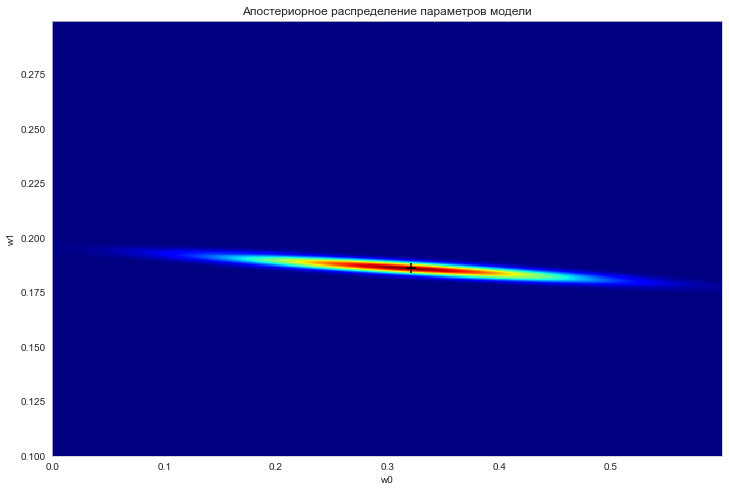

In [17]:
# Расчет параметров апостериорного распределения
mu, S = calc_aposterior_params(sigma_0, S_0, x_train_1, y_train, sigma)

# Нарисуем распределение
plt.figure(figsize=(12, 8))
# Расчет аопстериорного распределения
Z = calc_aposterior_distribution(x_start = -0.0, x_stop = 0.6, y_start = 0.1, y_stop = 0.3, step = 0.0005, mu = mu, S = S)
# Нанесем точку с параметрами обученной модели
plt.scatter(params[0], params[1], marker='+', s = 100, c = 'black')


[К содержанию](#zero-bullet) 

#### II.2.c. Сэмплирование экспонент <a class="anchor" id="II.2.c"></a>  
*Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая 2020 года? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).*  

In [18]:
# Функция для отрисовки сэмплированных экспонент
def plot_sample_exp(mu, S, num_samples, points, x_start, x_stop, y_start, y_stop):
    # Сэмплируем веса
    w_arr = np.random.multivariate_normal(mu, S, num_samples)
    # Настраиваем параметры графика
    ax = fig.add_subplot(111)
    ax.set_xlim((x_start, x_stop))
    ax.set_ylim((y_start, y_stop))
    ax.set_xlabel('Дни, начиная с ' + str(START_DATE.date()))
    ax.set_ylabel('Количество заболевших')
    xs = np.arange(x_start, x_stop)
    # Для каждого сэмпла строим соответствующие кривые
    for w in w_arr:
        plt.plot(xs, np.exp(w[0] + w[1] * xs), 'k-', lw=.4)
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=100)
    return w_arr

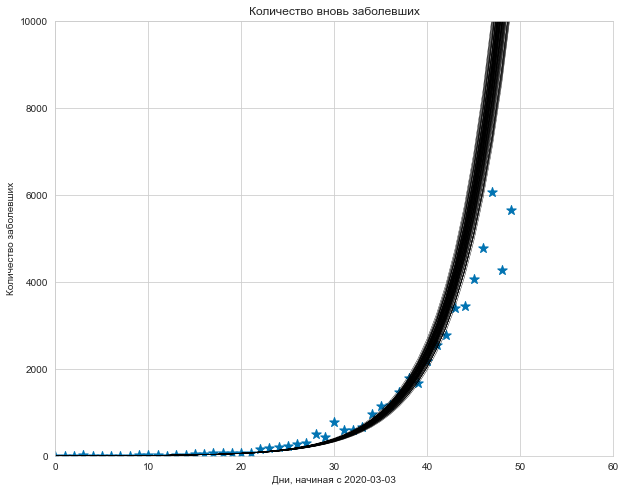

In [19]:
# Отрисовка сэмплированных экспонент
fig = plt.figure(figsize=(10, 8))
plt.title('Количество вновь заболевших')
w_arr = plot_sample_exp(mu = mu, S = S, num_samples = 100, points = (x_train, np.exp(y_train)), 
                        x_start = 0, x_stop = 60, y_start = 0, y_stop = 10000)

Рассчитаем количество новых случаев коронавируса, используя сэмплированные значения из апостериорного распределения параметров модели. Для этого по каждому семплу весов модели построим предсказание и усредним значение.

In [20]:
# Даты, на которые будем строить предсказания - год, месяц, день
prediction_dates = [#20,
                    (datetime.datetime(2020, 5, 1, 0, 0) - START_DATE).days,
                    (datetime.datetime(2020, 6, 1, 0, 0) - START_DATE).days,
                    (datetime.datetime(2020, 9, 1, 0, 0) - START_DATE).days
                    ]
predictions = []

for prediction_date in prediction_dates:
    y_pred = np.exp(w_arr[:, 0] + w_arr[:,1] * prediction_date)
    predictions.append(np.round(y_pred.mean(), 0))    

In [21]:
for i in range(len(predictions)):
    print('Предсказание модели на', (START_DATE + datetime.timedelta(days=prediction_dates[i])).date(), ':',
          int(predictions[i]), 'вновь заболевших')

Предсказание модели на 2020-05-01 : 80126 вновь заболевших
Предсказание модели на 2020-06-01 : 25789340 вновь заболевших
Предсказание модели на 2020-09-01 : 747749202553210 вновь заболевших


Как видно по результатам предсказания, чем позже мы вибираем дату прогноза от обучающего периода, тем более пессимистический прогноз делает модель.

In [22]:
# Функция для сэмплирования параметров модели из распределения
def sample_statistics(mu, sigma, num_points, x_start, x_stop):
    # Заполняем массив х
    xs = np.arange(x_start, x_stop)
    # Делаем сэмплирование параметров модели
    w_arr = np.random.multivariate_normal(mu, sigma, num_points)
    res = np.zeros((num_points, xs.shape[0]))
    # Для каждой сэмлированной модели делаем предсказание
    for i, w in enumerate(w_arr):
        res[i,:] = w[0] + w[1] * xs
    # Возвращаем массив размера (num_points, len(xs))
    return res

In [23]:
# Функция для построения эмпирического предсказательного распределения
def plot_predictions(params, statistics, sigma, x_start, x_stop, y_start, y_stop):
    xs = np.arange(x_start, x_stop)
    ax = fig.add_subplot(111)
    ax.set_xlim((x_start, x_stop))
    ax.set_ylim((y_start, y_stop))
    ax.plot(xs, (df['new_cases'][:x_stop]), label = "Наблюдаемые данные")
    ys = (params[0] + params[1] * xs)
    ax.plot(xs, np.exp(ys), color="red", label = "MAP гипотеза")
    ax.fill_between(xs, np.exp(ys - sigma), np.exp(ys + sigma), 
                    color = palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, 
                    np.exp(np.mean(statistics, axis=0) - np.std(statistics, axis=0)), 
                    np.exp(np.mean(statistics, axis=0) + np.std(statistics, axis=0)), 
                    color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend()

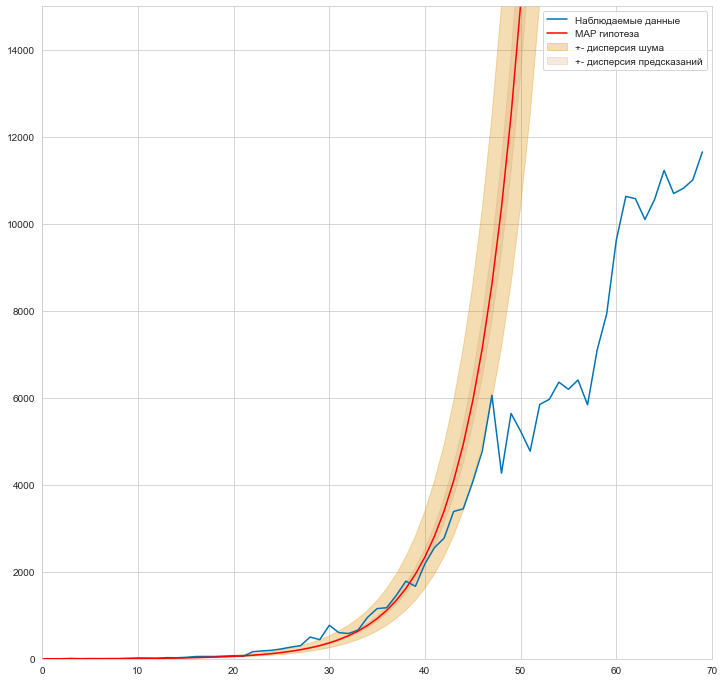

In [24]:
x_stop = 70
statistics = sample_statistics(mu, S, num_points = 1000, x_start = 0, x_stop = x_stop)
fig = plt.figure(figsize = (12, 12))
plot_predictions(params, statistics, sigma, x_start = 0, x_stop = x_stop, y_start = 0, y_stop = 15000)

Вывод: как и предполагалось ранее при визуальном анализе графиков, использование экспоненциальной модели для описания поведения реального количества вновь заболевших оказалось черезчур пессимистичным.  
[К содержанию](#zero-bullet) 

### II.3. Использование сигмоидной модели <a class="anchor" id="II.3"></a>  
*Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана (https://en.wikipedia.org/wiki/Probit_model):*

$$\Phi(x) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-t^2/2}dt$$

*Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t*

[К содержанию](#zero-bullet) 

#### II.3.a. Линейная модель для сигмоиды <a class="anchor" id="II.3.a"></a>  
*Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.*  

Будем исходить из следующих соображений. Разность общего количество больных за два последовательных дня будет равна суточному приросту количества заболевших. Отюда следует, что модель, описывающая общее количество заболевших, с точностью до постоянного множителя является первообразной для функции суточного прироста больных. Таким образом, если мы предполагаем, что характер изменения общего количества заболевших описывается вышеупомнутой формулой, то в этом случае суточный прирост количества больных должен быть пропорциональным производной Ф'(x), т.е. подинтегральным выражением:
$$\Phi'(x)  \sim  "newcases" \implies  "newcases" \sim e^{-x^2/2}$$  
Для описания этой зависимости с помощью линейной модели прологарифмируем выражение, и используем линейную модель, на вход которой помимо исходного признака (время с начала анализа) будем также подавать квадрат его значения:  
$$ln(y_{newcases}) \sim w^Tx_n$$
$$x_n = (x^2, x, 1)^T$$  

После обучения модели для обратного перехода к прогнозу общего количества заболевших, используем следующую формулу:
$$\Phi(x) \sim \sum_{i=0}^x e^{y_{newcases}}$$

In [25]:
# Размер обучающей выборки
TRAIN_SIZE = 50
# Предсказываемая переменная
TARGET = 'new_cases'
# Функция трасформации данных
def transform(x):
    return np.log(x)

# Создаем обучающий набор данных
x_train = np.arange(TRAIN_SIZE).reshape(-1, 1)
x_train = np.hstack((x_train, x_train ** 2))
# Добавим фиктивный признак, состоящий из всех единиц, для корректности вычислений
x_train_1 = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
# Трасформация целевой переменной
y_train = transform(df[TARGET][:TRAIN_SIZE].values)
# Обучим модель
model = LinearRegression(fit_intercept = True).fit(x_train, y_train)
params = [model.intercept_, model.coef_[0], model.coef_[1]]
print('Параметры обученной модели: ', params)

Параметры обученной модели:  [-0.3965904028416247, 0.27562283190276415, -0.0018297906166869172]


[К содержанию](#zero-bullet) 

#### II.3.b. Апостериорное распределение параметров <a class="anchor" id="II.3.b"></a>  
*Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для 
достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же 
максимальной апостериорной модели.*  

Данный пункт задания будем делать по аналогии с тем, как делали в II.2.b

In [26]:
# Параметры априорного распределения: дисперсия (одинаковая для всех компонент) и матрица ковариации
sigma_0 = 1 
S_0 = sigma_0 * np.diag((1, 1, 1))

# Минимизируем функцию по параметру beta:
res = minimize(empirical_bayes, 0, method='nelder-mead')
# Рассчитаем значение 
sigma = 1 / res.x[0]
print('Дисперсия шума в данных: ', sigma)

# Расчет параметров апостериорного распределения
mu, S = calc_aposterior_params(sigma_0, S_0, x_train_1, y_train, sigma)
print('Параметры апостериорного распределения весов модели:')
print('Среднее значение: ', mu)
print('Матрица ковариации: \n', S)

Дисперсия шума в данных:  0.2544448331796059
Параметры апостериорного распределения весов модели:
Среднее значение:  [-0.39212811  0.27525525 -0.00182354]
Матрица ковариации: 
 [[ 1.06534048e-02 -8.60712751e-04  1.44899277e-05]
 [-8.60712751e-04  9.51759729e-05 -1.81816215e-06]
 [ 1.44899277e-05 -1.81816215e-06  3.71506279e-08]]


[К содержанию](#zero-bullet) 

#### II.3.c. Сэмплирование сигмоид <a class="anchor" id="II.3.c"></a>  
*Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?*  

In [27]:
# Функция для отрисовки сэмплированных экспонент
def plot_sample_sig(mu, S, num_samples, points, x_start, x_stop, y_start, y_stop):
    # Сэмплируем веса
    w_arr = np.random.multivariate_normal(mu, S, num_samples)
    # Настраиваем параметры графика
    ax = fig.add_subplot(111)
    ax.set_xlim((x_start, x_stop))
    ax.set_ylim((y_start, y_stop))
    ax.set_xlabel('Дни, начиная с ' + str(START_DATE.date()))
    ax.set_ylabel('Количество заболевших')
    xs = np.arange(x_start, x_stop)
    # Для каждого сэмпла строим соответствующие кривые
    for w in w_arr:
        plt.plot(xs, np.cumsum(np.exp(w[0] + w[1] * xs + w[2] * xs ** 2)), 'k-', lw=.4)
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=100, c = 'red')
    return w_arr

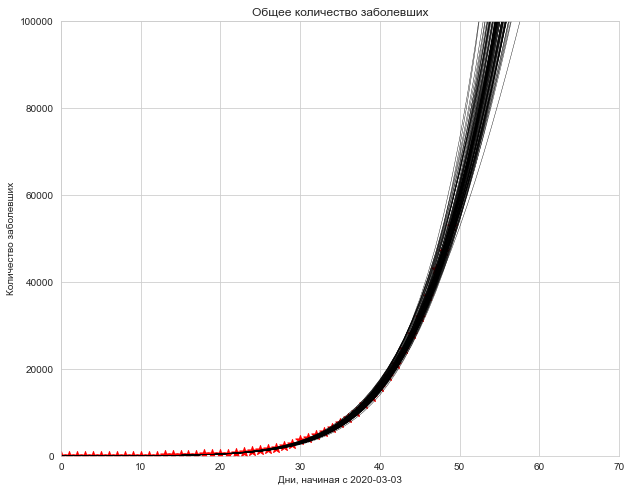

In [28]:
# Отрисовка сэмплированных сигмоид
fig = plt.figure(figsize=(10, 8))
plt.title('Общее количество заболевших')
w_arr = plot_sample_sig(mu = mu, S = S, num_samples = 100, points = (x_train[:,0], np.cumsum(np.exp(y_train))), 
                        x_start = 0, x_stop = 70, y_start = 0, y_stop = 100000)

Предскажем общее число случаев коронавируса, используя сэмплированные значения из апостериорного распределения параметров модели. Для этого по каждому семплу весов модели построим предсказание и усредним значение.  
[К содержанию](#zero-bullet) 

In [29]:
# Даты, на которые будем строить предсказания - год, месяц, день
prediction_dates = [
                    (datetime.datetime(2020, 5, 1, 0, 0) - START_DATE).days,
                    (datetime.datetime(2020, 6, 1, 0, 0) - START_DATE).days,
                    (datetime.datetime(2020, 9, 1, 0, 0) - START_DATE).days,
                    ]
predictions = []
# Создадим массив времен до самой последней даты из списка
xs = np.arange(0, max(prediction_dates))
# Векторизованно рассчитаем предсказания сигмоиды вплоть до максимальной даты по всем сэмплам
tmp = np.cumsum(np.exp(w_arr[:, 0].reshape(-1,1) + w_arr[:, 1].reshape(-1,1) * xs + 
                       w_arr[:, 2].reshape(-1,1) * xs ** 2), axis = 1)
# Усредним предсказания по всем сэмплам
tmp = tmp.sum(axis = 0)
# Выберем из кумулятивной кривой те даты, которые нам нужны
for date in prediction_dates:
    predictions.append(tmp[date - 1])

In [30]:
for i in range(len(predictions)):
    print('Предсказание модели на', (START_DATE + datetime.timedelta(days=prediction_dates[i])).date(), ':',
          int(predictions[i]), 'общее количество заболевших')

Предсказание модели на 2020-05-01 : 13846275 общее количество заболевших
Предсказание модели на 2020-06-01 : 78483698 общее количество заболевших
Предсказание модели на 2020-09-01 : 120727120 общее количество заболевших


**Примечание:** на первый взгляд может показаться странным, что предсказания не выходят на асимптоту с увеличением даты. Этот факт объясняется тем, что мы делаем усредненный прогноз по всем сэмплированным сигмоидам. Как можно видеть на рисунке выше, сэмплы в наборе случайны, и среди набора часто оказывается такая сигмоида, которая насыщается очень далеко. Суммирование такой сигмоиды со всеми остальными (даже если те уже насытились) в итоге даст ненасыщенную кривую.  
[К содержанию](#zero-bullet) 

In [31]:
# Функция для сэмплирования параметров модели из распределения
def sample_statistics_sigma(mu, sigma, num_points, x_start, x_stop):
    # Заполняем массив х
    xs = np.arange(x_start, x_stop)
    # Делаем сэмплирование параметров модели
    w_arr = np.random.multivariate_normal(mu, sigma, num_points)
    res = np.zeros((num_points, xs.shape[0]))
    # Для каждой сэмлированной модели делаем предсказание
    for i, w in enumerate(w_arr):
        res[i,:] = w[0] + w[1] * xs + w[2] * xs ** 2
    # Возвращаем массив размера (num_points, len(xs))
    return res

In [32]:
statistics = sample_statistics_sigma(mu, S, num_points = 1000, x_start = 0, x_stop = 60)

In [33]:
# Функция для построения эмпирического предсказательного распределения
def plot_predictions_sigma(params, statistics, sigma, x_start, x_stop, y_start, y_stop):
    xs = np.arange(x_start, x_stop)
    ax = fig.add_subplot(111)
    ax.set_xlim((x_start, x_stop))
    ax.set_ylim((y_start, y_stop))
    ax.set_xlabel('Дни, начиная с ' + str(START_DATE.date()))
    ax.set_ylabel('Количество заболевших')
    ax.plot(xs, (df['total_cases'][:x_stop]), label = "Наблюдаемые данные")
    ys = (params[0] + params[1] * xs + params[2] * xs ** 2)
    ax.plot(xs, np.cumsum(np.exp(ys)), color="red", label = "MAP гипотеза")
    ax.fill_between(xs, np.cumsum(np.exp(ys - sigma)), np.cumsum(np.exp(ys + sigma)), 
                    color = palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, 
                    np.cumsum(np.exp(np.mean(statistics, axis=0) - np.std(statistics, axis=0))), 
                    np.cumsum(np.exp(np.mean(statistics, axis=0) + np.std(statistics, axis=0))), 
                    color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend()

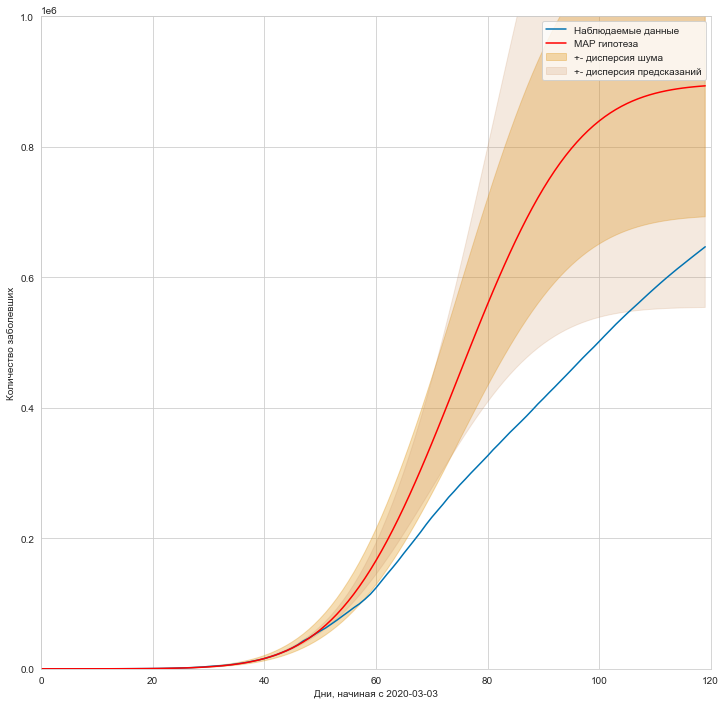

In [34]:
x_stop = 120
statistics = sample_statistics_sigma(mu, S, num_points = 1000, x_start = 0, x_stop = x_stop)
fig = plt.figure(figsize = (12, 12))
plot_predictions_sigma(params, statistics, sigma, x_start = 0, x_stop = x_stop, y_start = 0, y_stop = 1000000)

[К содержанию](#zero-bullet) 

### II.4. Анализ по другим странам <a class="anchor" id="II.4"></a>  

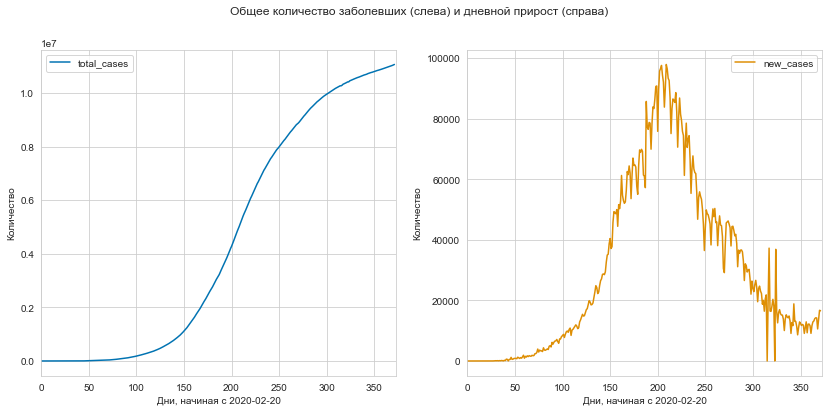

In [35]:
# Страна и дата, начиная с которой будем рассматривать данные
COUNTRY = 'India'
START_DATE = datetime.datetime(2020, 2, 20)

# Считываем данные
df = pd.read_csv('owid-covid-data.csv', parse_dates= ['date'])
# Оставляем только нужные столбцы
df = df[['location', 'date', 'total_cases', 'new_cases']]
# Выбираем страну и дату, с которой начнем обработку
df = df[(df['location'] == COUNTRY) & (df['date'] >= START_DATE)]
# Исправляем нулевые значения на единичные
zero_elements = df[df['new_cases'] <= 0].index
df.loc[df.index.isin(zero_elements), 'new_cases'] = 1
df = df.reset_index(drop = True)

df[['total_cases', 'new_cases']].plot(kind='line', subplots=True, grid=True, 
                                      title= 'Общее количество заболевших (слева) и дневной прирост (справа)',
                                      layout=(1, 2), sharex=True, sharey=False, legend=True,
                                      figsize = (14, 6), xlim = (0, len(df) + 1), 
                                      xlabel = 'Дни, начиная с ' + str(START_DATE.date()),
                                      ylabel = 'Количество')
plt.show()

[К содержанию](#zero-bullet) 

#### II.4.1. Экспоненциальная модель <a class="anchor" id="II.4.1"></a>  

In [36]:
# Размер обучающей выборки
TRAIN_SIZE = 100
# Предсказываемая переменная
TARGET = 'new_cases'

# Создаем обучающий набор данных
x_train = np.arange(TRAIN_SIZE).reshape(-1, 1)
# Добавим фиктивный признак, состоящий из всех единиц, для корректности вычислений
x_train_1 = np.hstack((np.ones(x_train.shape), x_train))
# Трасформация целевой переменной
y_train = np.log(df[TARGET][:TRAIN_SIZE].values)
# Обучим модель
model = LinearRegression(fit_intercept = True).fit(x_train, y_train)
params = [model.intercept_, model.coef_[0]]
print('Параметры модели: ', params)

Параметры модели:  [0.3983174113384971, 0.10039557194975593]


In [37]:
# Параметры априорного распределения: дисперсия (одинаковая для всех компонент) и матрица ковариации
sigma_0 = 1 
S_0 = sigma_0 * np.diag((1, 1))

# Минимизируем функцию по параметру beta:
res = minimize(empirical_bayes, 0, method='nelder-mead')
# Рассчитаем дисперсию шума
sigma = 1 / res.x[0]
print('Дисперсия шума в данных: ', sigma)

Дисперсия шума в данных:  0.8527420988114898


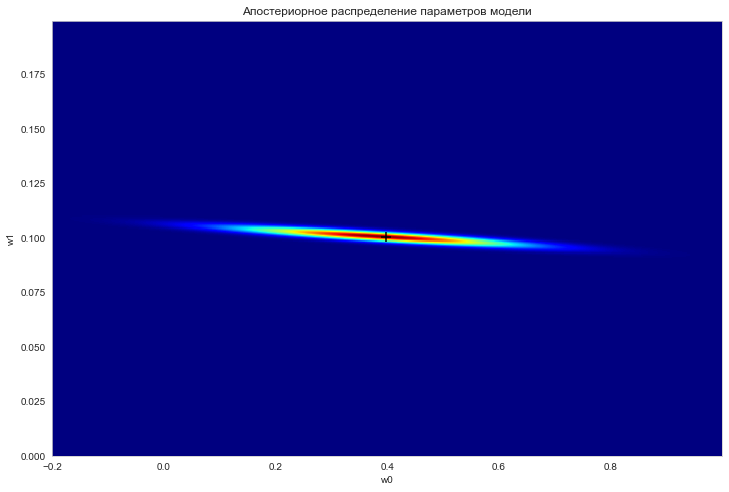

In [38]:
# Расчет параметров апостериорного распределения
mu, S = calc_aposterior_params(sigma_0, S_0, x_train_1, y_train, sigma)

# Нарисуем распределение
plt.figure(figsize=(12, 8))
# Расчет аопстериорного распределения
Z = calc_aposterior_distribution(x_start = -0.2, x_stop = 1.0, y_start = 0, y_stop = 0.2, step = 0.0005, mu = mu, S = S)
# Нанесем точку с параметрами обученной модели
plt.scatter(params[0], params[1], marker='+', s = 100, c = 'black')
plt.show()

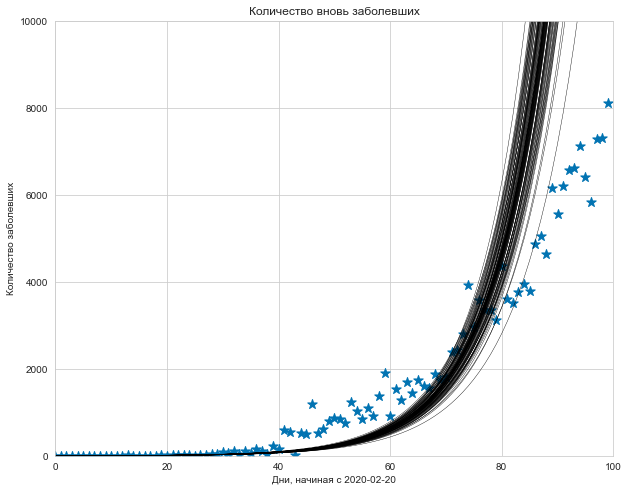

In [39]:
# Отрисовка сэмплированных экспонент
fig = plt.figure(figsize=(10, 8))
plt.title('Количество вновь заболевших')
w_arr = plot_sample_exp(mu = mu, S = S, num_samples = 100, points = (x_train, np.exp(y_train)), 
                        x_start = 0, x_stop = 100, y_start = 0, y_stop = 10000)

In [40]:
# Даты, на которые будем строить предсказания - год, месяц, день
prediction_dates = [#20,
                    (datetime.datetime(2020, 5, 1, 0, 0) - START_DATE).days,
                    (datetime.datetime(2020, 6, 1, 0, 0) - START_DATE).days,
                    (datetime.datetime(2020, 9, 1, 0, 0) - START_DATE).days
                    ]
predictions = []

for prediction_date in prediction_dates:
    y_pred = np.exp(w_arr[:, 0] + w_arr[:,1] * prediction_date)
    predictions.append(np.round(y_pred.mean(), 0)) 
    
for i in range(len(predictions)):
    print('Предсказание модели на', (START_DATE + datetime.timedelta(days=prediction_dates[i])).date(), ':',
          int(predictions[i]), 'вновь заболевших')

Предсказание модели на 2020-05-01 : 1886 вновь заболевших
Предсказание модели на 2020-06-01 : 43231 вновь заболевших
Предсказание модели на 2020-09-01 : 495356103 вновь заболевших


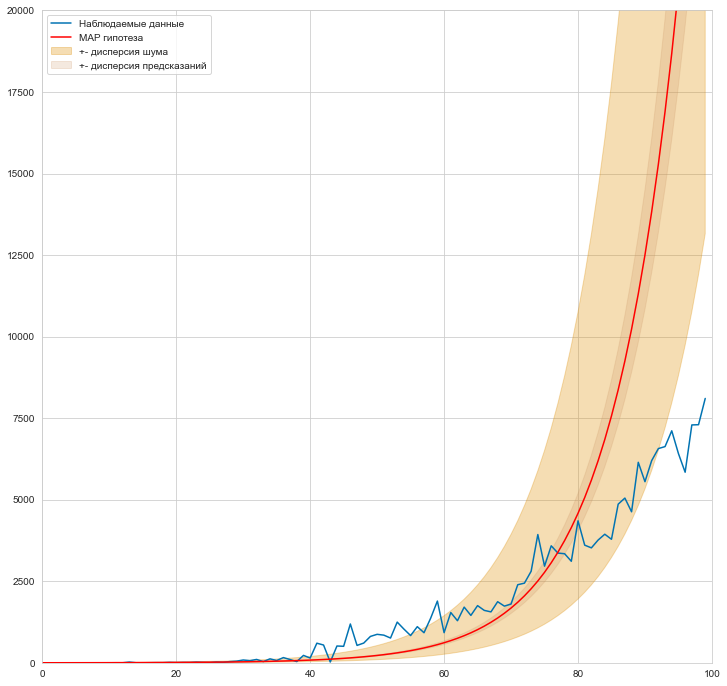

In [41]:
x_stop = 100
# Cэмплирование параметров модели из распределения
statistics = sample_statistics(mu, S, num_points = 1000, x_start = 0, x_stop = x_stop)
fig = plt.figure(figsize = (12, 12))
plot_predictions(params, statistics, sigma, x_start = 0, x_stop = x_stop, y_start = 0, y_stop = 20000)

На примере Индии экспоненциальная модель роста количества новых больных не очень хорошо аппроксимирует даже начальный участок кривой. Видимо, рост носил более сглаженный характер.  
[К содержанию](#zero-bullet) 

#### II.4.2. Сигмоидная модель <a class="anchor" id="II.4.2"></a>  

In [42]:
# Размер обучающей выборки
TRAIN_SIZE = 300
# Предсказываемая переменная
TARGET = 'new_cases'
# Функция трасформации данных
def transform(x):
    return np.log(x)

# Создаем обучающий набор данных
x_train = np.arange(TRAIN_SIZE).reshape(-1, 1)
x_train = np.hstack((x_train, x_train ** 2))
# Добавим фиктивный признак, состоящий из всех единиц, для корректности вычислений
x_train_1 = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
# Трасформация целевой переменной
y_train = transform(df[TARGET][:TRAIN_SIZE].values)
# Обучим модель
model = LinearRegression(fit_intercept = True).fit(x_train, y_train)
params = [model.intercept_, model.coef_[0], model.coef_[1]]
print('Параметры обученной модели: ', params)

Параметры обученной модели:  [0.8017305707324152, 0.10476955381037045, -0.0002543902027446605]


In [43]:
# Параметры априорного распределения: дисперсия (одинаковая для всех компонент) и матрица ковариации
sigma_0 = 1 
S_0 = sigma_0 * np.diag((1, 1, 1))

# Минимизируем функцию по параметру beta:
res = minimize(empirical_bayes, 0, method='nelder-mead')
# Рассчитаем значение 
sigma = 1 / res.x[0]
print('Дисперсия шума в данных: ', sigma)

# Расчет параметров апостериорного распределения
mu, S = calc_aposterior_params(sigma_0, S_0, x_train_1, y_train, sigma)
print('Параметры апостериорного распределения весов модели:')
print('Среднее значение: ', mu)
print('Матрица ковариации: \n', S)

Дисперсия шума в данных:  0.40611198537996807
Параметры апостериорного распределения весов модели:
Среднее значение:  [ 7.97842006e-01  1.04821457e-01 -2.54534575e-04]
Матрица ковариации: 
 [[ 4.85869319e-03 -6.48904066e-05  1.80552023e-07]
 [-6.48904066e-05  1.16132477e-06 -3.64125179e-09]
 [ 1.80552023e-07 -3.64125179e-09  1.21847179e-11]]


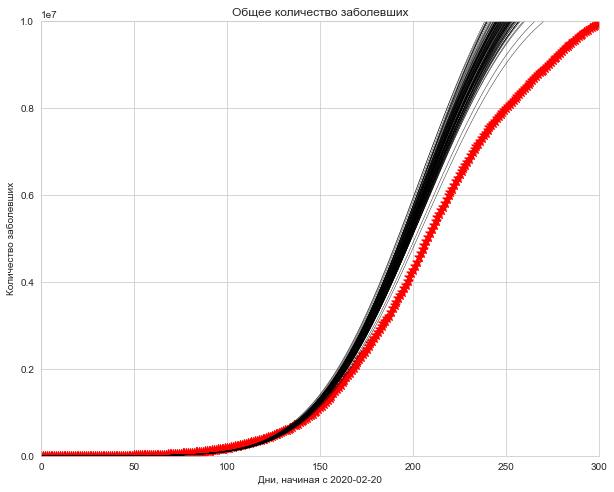

In [44]:
# Отрисовка сэмплированных сигмоид
fig = plt.figure(figsize=(10, 8))
plt.title('Общее количество заболевших')
w_arr = plot_sample_sig(mu = mu, S = S, num_samples = 100, points = (x_train[:,0], np.cumsum(np.exp(y_train))), 
                        x_start = 0, x_stop = 300, y_start = 0, y_stop = 10000000)

In [45]:
# Даты, на которые будем строить предсказания - год, месяц, день
prediction_dates = [20,
                    (datetime.datetime(2020, 5, 1, 0, 0) - START_DATE).days,
                    (datetime.datetime(2020, 6, 1, 0, 0) - START_DATE).days,
                    (datetime.datetime(2020, 9, 1, 0, 0) - START_DATE).days,
                    ]
predictions = []
# Создадим массив времен до самой последней даты из списка
xs = np.arange(0, max(prediction_dates))
# Векторизованно рассчитаем предсказания сигмоиды вплоть до максимальной даты по всем сэмплам
tmp = np.cumsum(np.exp(w_arr[:, 0].reshape(-1,1) + w_arr[:, 1].reshape(-1,1) * xs + 
                       w_arr[:, 2].reshape(-1,1) * xs ** 2), axis = 1)
# Усредним предсказания по всем сэмплам
tmp = tmp.sum(axis = 0)
# Выберем из кумулятивной кривой те даты, которые нам нужны
for date in prediction_dates:
    predictions.append(tmp[date - 1])
    
for i in range(len(predictions)):
    print('Предсказание модели на', (START_DATE + datetime.timedelta(days=prediction_dates[i])).date(), ':',
          int(predictions[i]), 'общее количество заболевших')

Предсказание модели на 2020-03-11 : 13697 общее количество заболевших
Предсказание модели на 2020-05-01 : 1347807 общее количество заболевших
Предсказание модели на 2020-06-01 : 11089478 общее количество заболевших
Предсказание модели на 2020-09-01 : 467268492 общее количество заболевших


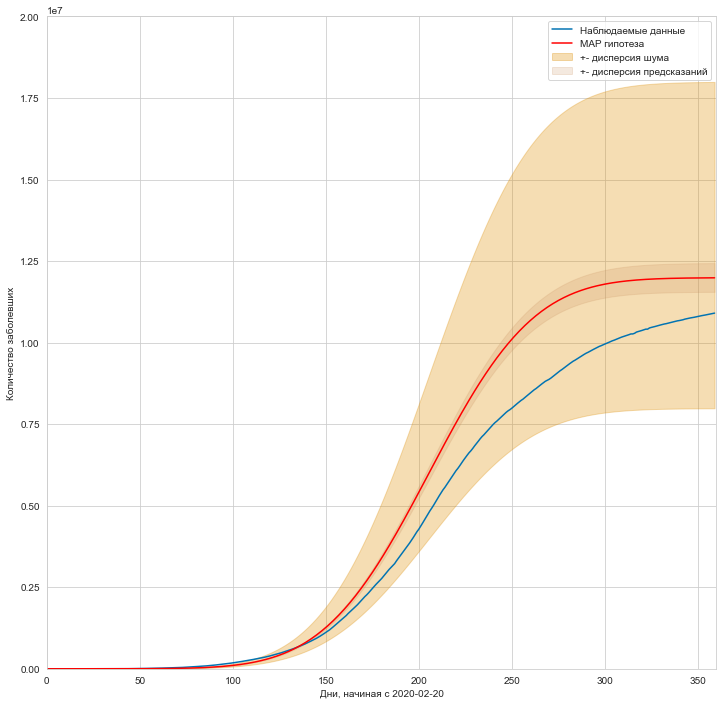

In [46]:
statistics = sample_statistics_sigma(mu, S, num_points = 1000, x_start = 0, x_stop = 60)

x_stop = 360
statistics = sample_statistics_sigma(mu, S, num_points = 1000, x_start = 0, x_stop = x_stop)
fig = plt.figure(figsize = (12, 12))
plot_predictions_sigma(params, statistics, sigma, x_start = 0, x_stop = x_stop, y_start = 0, y_stop = 20000000)

На примере Индии настроить адекватные параметры сигмоидной модели удалось только после обучения на 300 примерах.  
[К содержанию](#zero-bullet) 

## Сравнение результатов по странам  <a class="anchor" id="II.5"></a>  
Параметры экспоненциальной модели для России:  
[0.3206875188996481, 0.18596309168510516]  
Параметры экспоненциальной модели для Индии:  
[0.3983174113384971, 0.10039557194975593]  

Параметры моделей экспоненциального роста числа новых больных достаточно похожи. Это неудивительно, поскольку для настройки моделей использовалась начальная часть данных, которые визуально носили взрывной характер, и данная особенность проявлялась практически во всех странах. Поэтому можно сделать осторожный нестрогий вывод, что использовать параметры экспоненциальной модели для кластеризации стран скорее всего нецелесообразно.  

Другая ситуация с параметрами сигмоидальных моделей:

Параметры сигмоидной модели для России:  
[-0.39659040284162383, 0.2756228319027641, -0.0018297906166869166]  
Параметры сигмоидной модели для Индии:  
[0.8017305707324187, 0.10476955381037044, -0.00025439020274466053]  

Видно, что коэффициенты отличаются от 2-х раз до почти десяти. Возможно, это объясняется разным характером протекания болезни в различных странах, и/или принятием определенных мер руководством страны. Использование параметров сигмоидных моделей видится более перспективным в качестве критериев для кластеризации стран. 

[К содержанию](#zero-bullet) 